This notebook contains several instructions and example of using GPU-accelerated libraries in Python to speedup your program. 

There are 3 main libraries that I will go through in this notebook:

* Numba: Compiling Python code to CUDA
* RAPIDS: Including cuDF and cuML for dataframe process and machine learning
* Dask: scalable GPU-accelerated library

# **Check device & import Numba**

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

### We can see that by choosing free GPU accelerator from Colab, we have a Tesla T4.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10755384166362227998
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14415560704
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7446063383026104132
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

### the output implies that a GPU is connected. 
### If we turn off the GPU connection in Colab, this will return None

'/device:GPU:0'

Numba is a friendly-to-use Python module for Python programmers to compile their code into CUDA and speedup their program. With Numba, Python users don’t need to learn beyond their scope to apply CUDA and GPU-acceleration techniques into their daily tasks.

In [ ]:
import numba ## import numba to accelerate Python code
from numba import cuda ## numba.cuda to accelerate Python code using CUDA
import numpy as np

# **numba.jit for CPU acceleration**

In [ ]:
a = np.random.rand(1000, 100)
b = np.random.rand(1000, 100)
c = np.random.rand(1000, 100)

## Matrix Multiplication

First, let's try with basic numba cuda code for matrix multiplication. In case you forget:

<br>

matrix-multiply-a.svg

### <font color='yellow'>Pure Python</font>

In [ ]:
### Matrix dot product with pure Numba
def python_matmul(a, b):

  ar, ac = a.shape
  br, bc = b.shape
  c = np.zeros((ar, bc))

  for i in range(ar):
    for j in range(bc):
      for k in range(br):
        c[i,j] += a[i, k]*b[k, j]

  return c

%time python_matmul(a,b.T)

CPU times: user 57.9 s, sys: 16.8 ms, total: 58 s
Wall time: 1min 2s


array([[23.93858594, 24.06126254, 25.55843154, ..., 23.33762356,
        24.98327806, 26.7462807 ],
       [27.28813602, 25.36752193, 26.60247254, ..., 22.75606426,
        27.20253505, 26.79729959],
       [27.36310988, 25.73719115, 26.85935509, ..., 21.72196397,
        26.58077718, 27.6521455 ],
       ...,
       [23.92749238, 22.75310854, 23.31710201, ..., 19.50774397,
        21.91657844, 23.80706779],
       [25.6683761 , 25.21018029, 26.80406577, ..., 21.15617961,
        25.87442357, 28.15595839],
       [24.94280867, 24.09507642, 25.23347388, ..., 19.78774397,
        23.07109763, 25.29337123]])

### <font color='yellow'>Using numba.jit </font>

In [ ]:
### Matrix dot product with Numba
@numba.jit(nopython=True) ##equivalent to @numba.njit
def numba_matmul(a, b):

  ar, ac = a.shape
  br, bc = b.shape
  c = np.zeros((ar, bc))

  for i in range(ar):
    for j in range(bc):
      for k in range(br):
        c[i,j] += a[i, k]*b[k, j]

  return c

%timeit numba_matmul(a,b.T)

127 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
@numba.jit
def matmul(a, b):
  c = np.dot(a,  b)
  return c

%timeit matmul(a,b.T)

5.8 ms ± 509 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**What is nopython ?**

The numba.jit decorator has 2 compilation modes, which are **nopython** and **object**. The nopython mode is to essentially compile the decorated function so that it will run entirely **without the involvement of the Python interpreter**. This is the recommended and best-practice way to use the numba.jit decorator as it leads to the best performance.

If not set as nopython mode, then the program will compile in the **object** mode. In this mode Numba will **identify loops that it can compile** and compile those into functions that run in machine code, and it will run the rest of the code in the interpreter. For best performance avoid using this mode!

As we can see above, the code with numba.jit decorator runs little bit faster than another one.

## Quick-sort algorithm

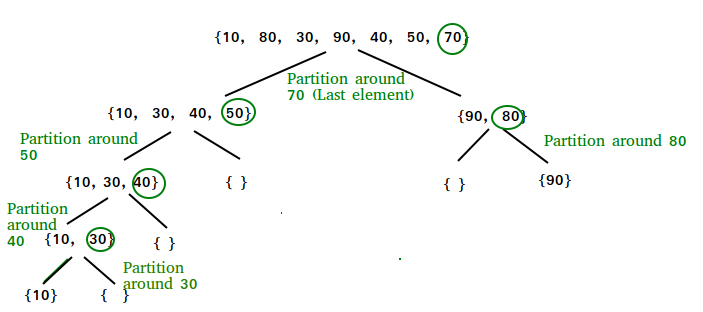

### <font color='yellow'>Pure Python</font>

In [ ]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(1500)

1000


In [ ]:
N = 1000000
arr = np.random.randint(0, N, N)
arr.shape

(1000000,)

In [ ]:
def partition(arr, low, high):
    i = (low - 1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller
        # than or equal to pivot
        if arr[j] <= pivot:
         
            # increment index of
            # smaller element
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return (i + 1)
 
# The main function that implements QuickSort
# arr[] --> Array to be sorted,
# low --> Starting index,
# high --> Ending index
 
# Function to do Quick sort
def quickSort(arr, low, high):
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi + 1, high)

n = len(arr)
     
# Calling quickSort function
%timeit quickSort(arr, 0, n - 1)

KeyboardInterrupt: ignored

In [ ]:
np.all(np.diff(arr) >= 0)

False

### <font color='yellow'>Using numba.jit</font>

In [ ]:
@numba.njit
def partition(arr, low, high):
    i = (low - 1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller
        # than or equal to pivot
        if arr[j] <= pivot:
         
            # increment index of
            # smaller element
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return (i + 1)
 
# The main function that implements QuickSort
# arr[] --> Array to be sorted,
# low --> Starting index,
# high --> Ending index
 
# Function to do Quick sort
def quickSort(arr, low, high):
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi + 1, high)

n = len(arr)
     
# Calling quickSort function
%timeit -r 5 -n 50 quickSort(arr, 0, n - 1)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-127-559fee6af63e>", line 41, in <module>
    get_ipython().run_line_magic('timeit', '-r 5 -n 50 quickSort(arr, 0, n - 1)')
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2314, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-53>", line 2, in timeit
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/execution.py", line 1162, in timeit
    all_runs = timer.repeat(repeat, number)
  File "/usr/lib/python3.7/timeit.py", line 205, in repeat
    t = self.timeit(number)
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/magics/execution.py", line 169, in timeit

RecursionError: ignored

In [ ]:
%time sorted(arr)

68.9 ms ± 11.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# **numba.cuda.jit for GPU acceleration**

First, note that numba.cuda kernel **don't return anything**, which means you must return results via parameters/arguments to the function. The starting point for this is usually some kind of numpy array.

## Matrix Multiplication

In [ ]:
###create some sample arrays
from numba import float32

N = 1000
a = np.random.rand(N, N)
b = np.random.rand(N, N)
c = cuda.device_array_like(a)

### save the array data to device

a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.device_array_like(a_device)

print(a_device.shape, b_device.shape, c_device.shape)

(1000, 1000) (1000, 1000) (1000, 1000)


The cuda code will take long time in the first run since it has to transfer all of the arrays into cuda device arrays. Therefore, in order to extra speed up, we can do it first before feeding the arrays to the cuda_matmul function

### <font color='yellow'>Using cuda.jit</font>

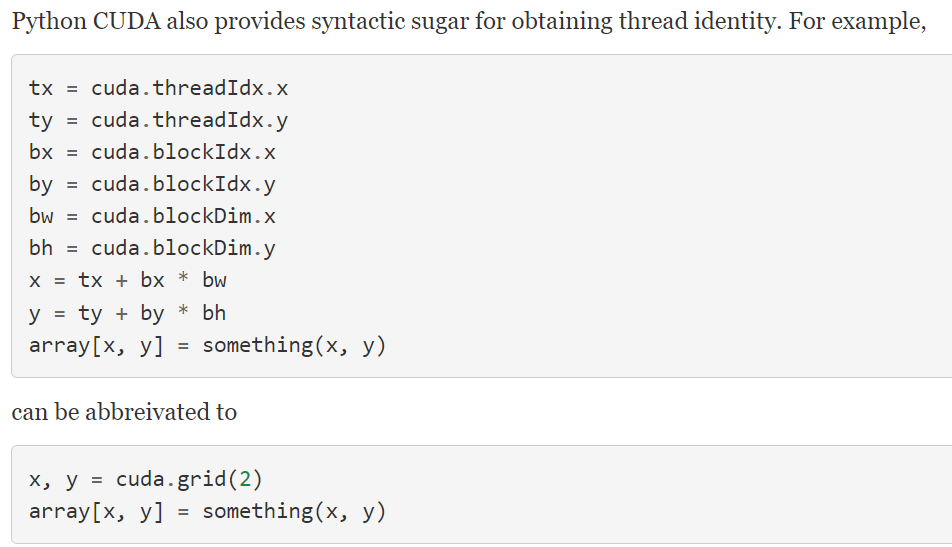

Notice that the function above doesn't return anything. In fact, it will override our variable **c** and add new value to the elements of **c**. When working with cuda.jit kernel, we assign tasks to the threads/grids/blocks so that it would do the computation parallelly and simultaneously.

We call **cuda.grid()** to access to the grid element and assign the task to that grid element.

In [ ]:
### using cuda.jit
@cuda.jit
def cuda_matmul(a, b, c):
    # like threadIdx.x + (blockIdx.x * blockDim.x)
    i, j = cuda.grid(2) ## call access to the cuda.grid

    if i < c.shape[0] and j < c.shape[1]:
      tmp = 0. ## define a temporary variable to later compute it and add it to the array.
      for k in range(a.shape[1]): ## go through each row to perform multiplication row-wise
        tmp += a[i, k]*b[k, j]
      
      c[i,j] = tmp

In [ ]:
### defining how the block will run

def driver():
  nthreads = (16, 16)
  nblocks_x = int(np.ceil(c.shape[0]/ nthreads[0]))
  nblocks_y = int(np.ceil(c.shape[1]/ nthreads[1]))
  nblocks = (nblocks_x, nblocks_y)
  
  cuda_matmul[nblocks, nthreads](a, b, c)
  return c.copy_to_host()

%timeit -r 5 -n 50 driver()

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


38.3 ms ± 2.52 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:
print(driver())

[[255.85689913 260.10293674 255.42125421 ... 253.05842709 255.49941114
  258.94439292]
 [246.36519604 251.40993086 244.47015052 ... 245.13036646 248.1350612
  251.98656562]
 [249.60246649 258.64897343 251.30693917 ... 244.49499007 253.25063603
  255.05675213]
 ...
 [258.42280087 262.95057279 252.19860496 ... 253.6986649  262.15270605
  255.18477009]
 [250.82582752 255.72840856 250.97701985 ... 251.0873566  252.26389258
  256.76028125]
 [249.27690597 255.65573084 245.88336093 ... 239.00767908 243.56598081
  253.57574142]]


What happens when we change the size of the array? One easy way out is to simply change the grid parameters (number of blocks and threads per block) in order to launch at least as many threads as there are elements in the array.

There is some science and some art to setting these parameters. For the "science", we will say that (a) they should be a multiple of two, typically between 32 and 1024, and (b) they should be chosen so as to maximize *occupancy* (how many threads are active at the same time). Nvidia provides a [spreadsheet](https://docs.nvidia.com/cuda/cuda-occupancy-calculator/index.html) that can help calculating these. For the "art", nothing can predict the behavior of your kernels, so if you truly want to optimize these parameters, you need to profile your code with typical inputs. In practice, a "reasonable" number of threads for modern GPUs is 256.

In [ ]:
def driver_fast():
  nthreads = (16, 16)
  nblocks_x = int(np.ceil(c.shape[0]/ nthreads[0]))
  nblocks_y = int(np.ceil(c.shape[1]/ nthreads[1]))
  nblocks = (nblocks_x, nblocks_y)
  
  cuda_matmul[nblocks, nthreads](a_device, b_device, c_device)
  return c_device.copy_to_host()

%timeit -r 5 -n 50 driver_fast()
### Super duper extra fast

29.3 ms ± 1.03 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:
print(driver_fast())

[[255.85689913 260.10293674 255.42125421 ... 253.05842709 255.49941114
  258.94439292]
 [246.36519604 251.40993086 244.47015052 ... 245.13036646 248.1350612
  251.98656562]
 [249.60246649 258.64897343 251.30693917 ... 244.49499007 253.25063603
  255.05675213]
 ...
 [258.42280087 262.95057279 252.19860496 ... 253.6986649  262.15270605
  255.18477009]
 [250.82582752 255.72840856 250.97701985 ... 251.0873566  252.26389258
  256.76028125]
 [249.27690597 255.65573084 245.88336093 ... 239.00767908 243.56598081
  253.57574142]]


In [ ]:
###copying time:
%timeit c_device.copy_to_host()

2.2 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### <font color='yellow'>Using cuda.jit with shared memory allocation</font>

We can even make it faster by allocating the shared memory. 

A limited amount of shared memory can be allocated on the device to speed up access to data, when necessary. That memory will be shared (i.e. both readable and writable) amongst all threads belonging to a given block and has faster access times than regular device memory. It also allows threads to cooperate on a given solution. You can think of it as a manually-managed data cache.

https://numba.pydata.org/numba-doc/latest/cuda/memory.html#local-memory

In [ ]:
a = a.astype(np.float32)
b = b.astype(np.float32)
c = cuda.device_array_like(a) #np.zeros((N,N), dtype = np.float32)

### save the array data to device

a_device = cuda.to_device(a)
b_device = cuda.to_device(b)
c_device = cuda.device_array_like(a_device)

print(a_device.shape, b_device.shape, c_device.shape)

(1000, 1000) (1000, 1000) (1000, 1000)


In [ ]:
from numba import float32
TPB = 16

@cuda.jit
def cuda_matmul_shared_memory(a, b, c):
  sA = cuda.shared.array(shape = (TPB, TPB), dtype = float32) ### create a shared array
  sB = cuda.shared.array(shape = (TPB, TPB), dtype = float32) ### create a shared array
  x, y = cuda.grid(2)

  tx = cuda.threadIdx.x
  ty = cuda.threadIdx.y
  bpg = cuda.gridDim.x

  if x < c.shape[0] and y < c.shape[1]:

    tmp =0.

    for i in range(bpg):
      sA[tx, ty] = a[x, ty + i*TPB] ### access to the element
      sB[tx, ty] = b[tx + i*TPB, y] ### access to the element

      cuda.syncthreads() ### sync all thread in a block

      for j in range(TPB):
        tmp += sA[tx, j] * sB[j, ty] ### compute 
    
      cuda.syncthreads()
  
    c[x, y] = tmp

In [ ]:
def driver_shared_memory():
  nthreads = (TPB, TPB)
  nblocks_xy = int(np.ceil(N/nthreads[0]))
  nblocks = (nblocks_xy, nblocks_xy)
  
  cuda_matmul_shared_memory[nblocks, nthreads](a, b, c)

  return c.copy_to_host()

%timeit -r 5 -n 50 driver_shared_memory()

/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


26.3 ms ± 3.14 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:
def driver_shared_memory_fast():
  nthreads = (TPB, TPB)
  nblocks_xy = int(np.ceil(N/nthreads[0]))
  nblocks = (nblocks_xy, nblocks_xy)
  
  cuda_matmul_shared_memory[nblocks, nthreads](a_device, b_device, c_device)

  return c_device.copy_to_host()

%timeit -r 5 -n 50 driver_shared_memory_fast()

20.5 ms ± 1.33 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


### <font color='yellow'> Visualize results </font>

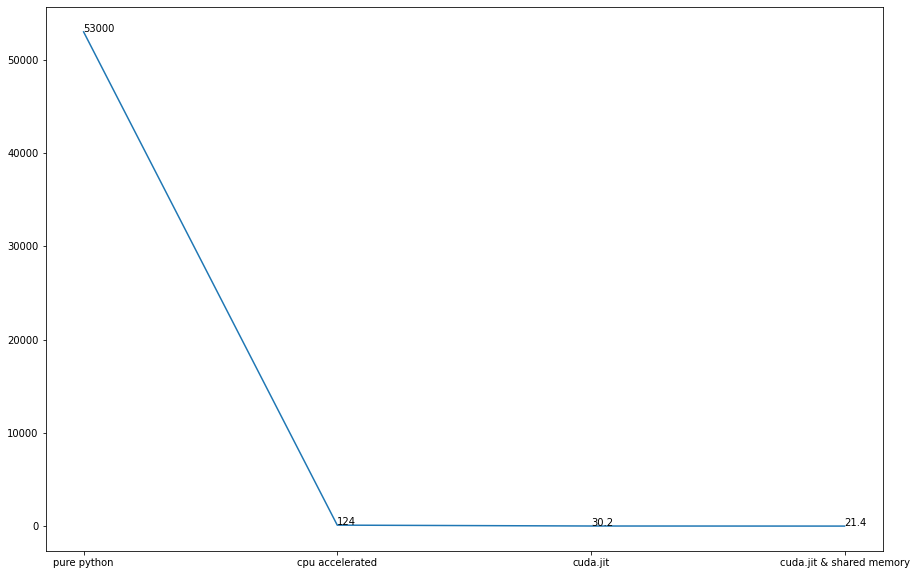

In [ ]:
###Visualization
import matplotlib.pyplot as plt
x = ['pure python', 'cpu accelerated', 'cuda.jit', 'cuda.jit & shared memory']
y = [53000, 124, 30.2, 21.4]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

plt.plot(x, y)

for i, txt in enumerate(y):
    ax.annotate(txt, (x[i], y[i]))

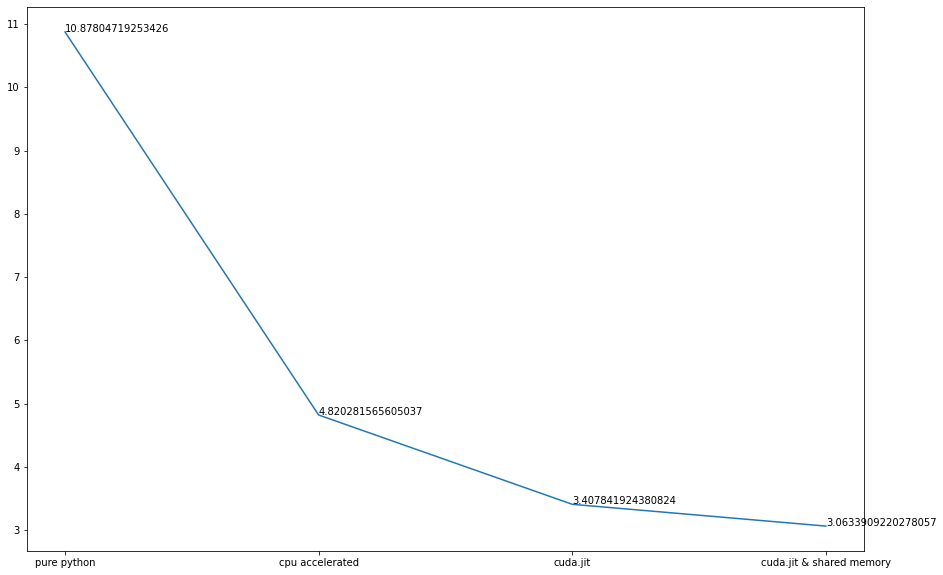

In [ ]:
###Visualization -log
import matplotlib.pyplot as plt
x = ['pure python', 'cpu accelerated', 'cuda.jit', 'cuda.jit & shared memory']
y = np.log([53000, 124, 30.2, 21.4])

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

plt.plot(x, y)

for i, txt in enumerate(y):
    ax.annotate(txt, (x[i], y[i]))

## Quick-sort algorithm

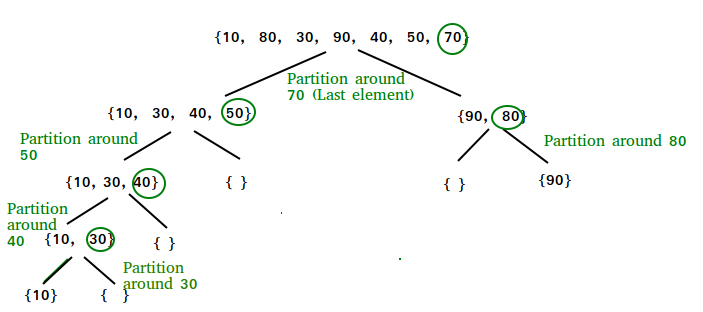

In [ ]:
from numba import njit, cuda
from numba.types import int32, float32

import numpy as np

from time import time
from warnings import warn
from pdb import set_trace

bits = 32
nb_float = float32
nb_int = int32
np_float = np.float32
np_int = np.int32

In [ ]:
N = 10000
arr = np.random.randint(0, N, N).reshape(1, N)
arr.shape

(1, 10000)

Basically, the implementation of quick-sort will have 2 main part:

**Partition function**

    Partition using pivot.

    Function takes last element as pivot, places the pivot element at its correct
    position in sorted array, and places all smaller (smaller than pivot) to left of
    pivot and all greater elements to right of pivot

    Parameters
    ----------
    arr : vector of floats
        The array to be sorted.
    ids : vector of ints
        The unsorted IDs corresponding to arr, in other words range(len(arr)).
    l : int
        Starting index for sorting.
    h : int
        Ending index for sorting.

    Returns
    -------
    int
        the new pivot? 

**Iterative sort function**:

    Perform iterative quicksort on array and an unsorted ID list of the array.

    Parameters
    ----------
    arr : vector of floats
        The array to be sorted.
    stack : vector of ints
        Array initialized with 0's
    ids : vector of ints
        The unsorted IDs corresponding to arr, in other words range(len(arr)).

    Returns
    -------
    None.

There is several ways to implement cuda-quicksort. I demo 2 version of it:
* Local memory: Create and store several stacks and arrays in local memory.
* Device memory: Create and store several stacks and arrays in device memory.

Local memory is an area of memory private to each thread. Using local memory helps allocate some scratchpad area when scalar local variables are not enough. The memory is allocated once for the duration of the kernel, unlike traditional dynamic memory management.

https://numba.pydata.org/numba-doc/latest/cuda/memory.html#local-memory

### <font color='yellow'> Using cuda.jit local memory </font>

In [ ]:
verbose = True

@cuda.jit(device=True)
def partition(arr, ids, l, h):

    # index of smaller element
    i = l - 1

    pivot = arr[h]

    for j in range(l, h):

        # If current element is smaller than or equal to pivot
        if arr[j] <= pivot:

            # increment index of smaller element
            i += 1
            arr[i], arr[j] = arr[j], arr[i]
            ids[i], ids[j] = ids[j], ids[i]

    arr[i + 1], arr[h] = arr[h], arr[i + 1]
    ids[i + 1], ids[h] = ids[h], ids[i + 1]

    return i + 1


@cuda.jit(device=True)
def quickSortIterative(arr, stack, ids):

    # low and high indices.
    l, h = (0, len(arr) - 1)
    # stack = [0] * size
    # ids = list(range(len(arr)))

    # initialize top of stack
    top = -1

    # fill ids with range(len(arr))
    for i in range(len(arr)):
        ids[i] = i
        stack[i] = 0

    # push initial values of l and h to stack
    top = top + 1
    stack[top] = l
    top = top + 1
    stack[top] = h

    # Keep popping from stack while is not empty
    while top >= 0:

        # Pop h and l
        h = stack[top]
        top = top - 1
        l = stack[top]
        top = top - 1

        # Set pivot element at its correct position in
        # sorted array
        p = partition(arr, ids, l, h)

        # If there are elements on left side of pivot,
        # then push left side to stack
        if p - 1 > l:
            top = top + 1
            stack[top] = l
            top = top + 1
            stack[top] = p - 1

        # If there are elements on right side of pivot,
        # then push right side to stack
        if p + 1 < h:
            top = top + 1
            stack[top] = p + 1
            top = top + 1
            stack[top] = h

@cuda.jit("void(float{0}[:,:], float{0}[:,:])".format(bits))
def local_array_sort(mat, out):
    # CUDA iterator
    idx = cuda.grid(1)
    nrows = mat.shape[0]

    if idx < nrows:
        vec = mat[idx]
        vals = cuda.local.array(N, nb_float) ## assign array
        sorter = cuda.local.array(N, nb_int) ## assign sorted array
        stack = cuda.local.array(N, nb_int) ## assign stack

        # fill vals with data
        for i in range(N):
            vals[i] = vec[i]

        # sorting
        quickSortIterative(vals, stack, sorter)

        # foo stuff using vals and sorter, in this case just outputting the values (MWE)
        for i in range(N):
            out[idx, i] = vals[i]

In [ ]:
def local_array_driver(mat):
    # block, grid
    block_dim = 5
    nrows = mat.shape[0]

    grid_dim = int(nrows / block_dim + 1)

    # CUDA
    stream = cuda.stream()
    cuda_mat = cuda.to_device(np.asarray(mat, dtype=np_float), stream=stream)
    cuda_out = cuda.device_array((nrows, N), np_float)

    local_array_sort[grid_dim, block_dim](cuda_mat, cuda_out)

    out = cuda_out.copy_to_host(stream=stream)

    return out

%timeit -r 5 -n 50 local_array_driver(arr)

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


38.7 ms ± 1.47 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:
# block, grid
block_dim = 5
nrows = arr.shape[0]

grid_dim = int(nrows / block_dim + 1)

# CUDA
stream = cuda.stream()
cuda_mat = cuda.to_device(np.asarray(arr, dtype=np_float), stream=stream)
cuda_out = cuda.device_array((nrows, N), np_float)
%time local_array_sort[grid_dim, block_dim](cuda_mat, cuda_out)

CPU times: user 211 µs, sys: 5 µs, total: 216 µs
Wall time: 226 µs


In [ ]:
###check if sorted
out = local_array_driver(arr)
np.all(np.diff(out) >= 0)

True

### <font color='yellow'> Using cuda.jit device memory</font>

Device array references have the following methods. These methods are to be called in host code, not within CUDA-jitted functions.

In [ ]:
@cuda.jit(device=True)
def quickSortIterativeDevice(arr, stack, ids):

    # low and high indices.
    l, h = (0, len(arr) - 1)
    # stack = [0] * size
    # ids = list(range(len(arr)))

    # initialize top of stack
    top = -1

    # push initial values of l and h to stack
    top = top + 1
    stack[top] = l
    top = top + 1
    stack[top] = h

    # Keep popping from stack while is not empty
    while top >= 0:

        # Pop h and l
        h = stack[top]
        top = top - 1
        l = stack[top]
        top = top - 1

        # Set pivot element at its correct position in
        # sorted array
        p = partition(arr, ids, l, h)

        # If there are elements on left side of pivot,
        # then push left side to stack
        if p - 1 > l:
            top = top + 1
            stack[top] = l
            top = top + 1
            stack[top] = p - 1

        # If there are elements on right side of pivot,
        # then push right side to stack
        if p + 1 < h:
            top = top + 1
            stack[top] = p + 1
            top = top + 1
            stack[top] = h

@cuda.jit("void(float{0}[:,:], int{0}[:,:], int{0}[:,:], float{0}[:,:])".format(bits))
def device_array_sort(mat, stack, sorter, out):
    # CUDA iterator
    idx = cuda.grid(1)
    nrows = mat.shape[0]

    if idx < nrows:
        vec = mat[idx]
        substack = stack[idx]
        subsorter = sorter[idx]

        # sorting (substack is already initialized to 0's, subsorter to list(range(cols)))
        quickSortIterativeDevice(vec, substack, subsorter)

        # foo stuff using vals and sorter, in this case just outputting the values (MWE)
        for i in range(N):
            out[idx, i] = vec[i]

In [ ]:
# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPBx = 16
TPBy = N

def device_array_driver(mat):
    # block, grid
    block_dim = 5
    nrows = mat.shape[0]
    grid_dim = int(nrows / block_dim + 1)

    # CUDA
    stream = cuda.stream()

    cuda_mat = cuda.to_device(np.asarray(mat, dtype=np_float), stream=stream)
    cuda_out = cuda.device_array((nrows, N), np_float)

    stack = np.zeros((nrows, N))
    sorter = np.tile(list(range(N)), (nrows, 1))
    cuda_stack = cuda.to_device(np.asarray(stack, dtype=np_int), stream=stream)
    cuda_sorter = cuda.to_device(np.asarray(sorter, dtype=np_int), stream=stream)

    device_array_sort[grid_dim, block_dim](cuda_mat, cuda_stack, cuda_sorter, cuda_out)

    out = cuda_out.copy_to_host(stream=stream)

    return out

%timeit -r 5 -n 50 device_array_driver(arr)

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


21.5 ms ± 1.28 ms per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:

    # block, grid
    block_dim = 5
    nrows = arr.shape[0]
    grid_dim = int(nrows / block_dim + 1)

    # CUDA
    stream = cuda.stream()

    cuda_mat = cuda.to_device(np.asarray(arr, dtype=np_float), stream=stream)
    cuda_out = cuda.device_array((nrows, N), np_float)

    stack = np.zeros((nrows, N))
    sorter = np.tile(list(range(N)), (nrows, 1))
    cuda_stack = cuda.to_device(np.asarray(stack, dtype=np_int), stream=stream)
    cuda_sorter = cuda.to_device(np.asarray(sorter, dtype=np_int), stream=stream)

    %timeit -r 5 -n 50  device_array_sort[grid_dim, block_dim](cuda_mat, cuda_stack, cuda_sorter, cuda_out)

90.9 µs ± 18.4 µs per loop (mean ± std. dev. of 5 runs, 50 loops each)


In [ ]:
###check if sorted
out = device_array_driver(arr)
np.all(np.diff(out) >= 0)

True

### <font color='yellow'> Visualize results </font>

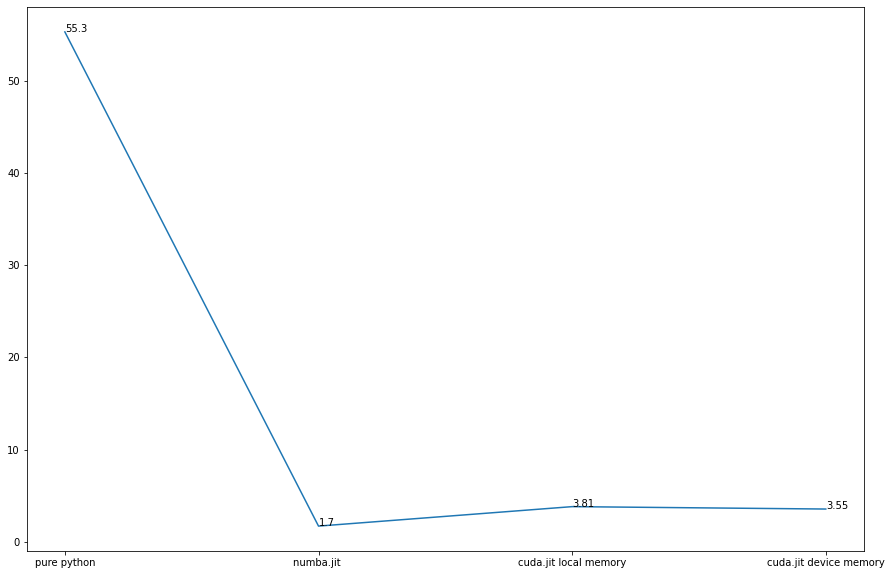

In [ ]:
###Visualization
import matplotlib.pyplot as plt
x = ['pure python', 'numba.jit ','cuda.jit local memory', 'cuda.jit device memory']
y = [55.3, 1.7, 3.81, 3.55]

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

plt.plot(x, y)

for i, txt in enumerate(y):
    ax.annotate(txt, (x[i], y[i]))

# **Other examples**

## Binary Tree

Source: https://github.com/numba/numba-examples/blob/master/legacy/binarytree.py

In [ ]:
"""
This is a more complicated jitclasses example.
Here, we implement a binarytree and iterative preorder and inorder traversal
function using a handwritten stack.
"""
from __future__ import print_function, absolute_import
import random
from collections import OrderedDict
from numba import njit
from numba import int32, deferred_type, optional
from numba.core.runtime import rtsys
from numba.experimental import jitclass

node_type = deferred_type()

spec = OrderedDict()
spec['data'] = int32
spec['left'] = optional(node_type)
spec['right'] = optional(node_type)


@jitclass(spec)
class TreeNode(object):
    def __init__(self, data):
        self.data = data
        self.left = None
        self.right = None


node_type.define(TreeNode.class_type.instance_type)

stack_type = deferred_type()

spec = OrderedDict()
spec['data'] = TreeNode.class_type.instance_type
spec['next'] = optional(stack_type)


@jitclass(spec)
class Stack(object):
    def __init__(self, data, next):
        self.data = data
        self.next = next


stack_type.define(Stack.class_type.instance_type)


@njit
def push(stack, data):
    return Stack(data, stack)


@njit
def pop(stack):
    return stack.next


@njit
def make_stack(data):
    return push(None, data)


@njit
def list_preorder(node):
    """
    Returns a list of the data by preorder traversing the tree
    """
    out = []

    stack = make_stack(node)

    while stack is not None:
        node = stack.data
        out.append(node.data)
        stack = pop(stack)

        if node.right is not None:
            stack = push(stack, node.right)
        if node.left is not None:
            stack = push(stack, node.left)

    return out


@njit
def list_inorder(node):
    """
    Returns a list of the data by inorder traversing the tree
    """

    out = []

    done = False

    current = node
    stack = None

    while not done:
        if current is not None:
            stack = push(stack, current)
            current = current.left

        else:
            if stack is not None:
                tos = stack.data
                out.append(tos.data)
                stack = pop(stack)
                current = tos.right
            else:
                done = True

    return out


def build_random_tree(size):
    """
    Create a randomly constructred tree that is fairly balanced
    """
    root = TreeNode(0)

    for i in range(1, size):
        cursor = root
        while True:
            choice = random.choice(['L', 'R'])
            if choice == 'L':
                if cursor.left:
                    cursor = cursor.left
                else:
                    cursor.left = TreeNode(i)
                    break
            elif choice == 'R':
                if cursor.right:
                    cursor = cursor.right
                else:
                    cursor.right = TreeNode(i)
                    break
    return root


def build_simple_tree():
    """
    Create a simple tree
    """
    node = TreeNode(1)
    node.left = TreeNode(2)
    node.right = TreeNode(3)
    node.right.left = TreeNode(4)
    node.right.right = TreeNode(5)
    return node


def run(tree):
    preorder = list_preorder(tree)
    print("== Preorder == ")
    print(preorder)

    inorder = list_inorder(tree)
    print("== Inorder == ")
    print(inorder)

    return preorder, inorder


def runme():
    print("== Simple Tree ==")
    preorder, inorder = run(build_simple_tree())
    assert preorder == [1, 2, 3, 4, 5]
    assert inorder == [2, 1, 4, 3, 5]

    print("== Big Random Tree ==")
    run(build_random_tree(100))


if __name__ == '__main__':
    runme()
    print("== Print memory allocation information == ")
    print(rtsys.get_allocation_stats())

== Simple Tree ==
== Preorder == 
[1, 2, 3, 4, 5]
== Inorder == 
[2, 1, 4, 3, 5]
== Big Random Tree ==
== Preorder == 
[0, 3, 4, 29, 65, 80, 43, 77, 83, 98, 8, 24, 37, 44, 78, 71, 67, 14, 33, 59, 72, 62, 88, 90, 81, 85, 89, 5, 17, 30, 34, 61, 53, 60, 94, 52, 58, 26, 36, 70, 73, 50, 51, 57, 92, 6, 11, 23, 41, 84, 21, 25, 7, 12, 91, 63, 48, 1, 2, 9, 10, 16, 31, 19, 39, 49, 64, 69, 76, 20, 47, 96, 13, 22, 99, 40, 82, 15, 54, 79, 18, 27, 35, 55, 87, 46, 93, 42, 45, 95, 28, 68, 86, 97, 32, 56, 74, 38, 66, 75]
== Inorder == 
[65, 80, 29, 77, 83, 43, 98, 4, 78, 44, 71, 37, 24, 67, 8, 72, 59, 33, 14, 88, 90, 62, 81, 85, 89, 3, 61, 34, 53, 94, 60, 30, 52, 58, 17, 70, 73, 36, 26, 50, 92, 57, 51, 5, 23, 84, 41, 11, 25, 21, 6, 91, 12, 63, 7, 48, 0, 31, 16, 19, 39, 10, 64, 69, 49, 76, 9, 96, 47, 20, 2, 99, 22, 82, 40, 13, 54, 15, 79, 1, 55, 87, 35, 46, 93, 27, 42, 95, 45, 18, 68, 97, 86, 28, 56, 74, 32, 66, 38, 75]
== Print memory allocation information == 
nrt_mstats(alloc=323, free=318, mi_alloc=

## Logarithmic Correction for image

Source: https://colab.research.google.com/drive/1GkGLDexnYUnl2ilmwNxAlWAH6Eo5ZK2f?usp=sharing#scrollTo=iyF3DF7sJcNm

Let's craft a 2D kernel to apply [logarithmic correction](https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.adjust_log) to an image.

Given an image $I(x, y)$ with values between 0 and 1, the log-corrected image is given by

$$I_c(x, y) = \gamma \log_2 (1 + I(x, y))$$

In [ ]:
from skimage import data

moon = data.moon().astype(np.float32) / 255.

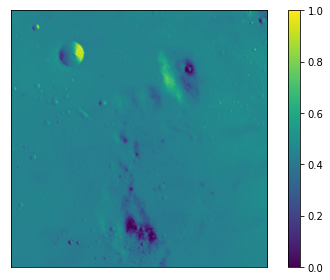

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(moon)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(im)
fig.tight_layout()

### <font color='yellow'> Pure Python </font>

In [ ]:
import math

def adjust_log(arr, gain):
  out = np.zeros((arr.shape[0], arr.shape[1]))

  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      out[i, j] = gain * math.log2(1 + arr[i, j])

  return out

%timeit adjust_log(moon, 0.9)

677 ms ± 9.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
moon_corr = adjust_log(moon, 0.9)

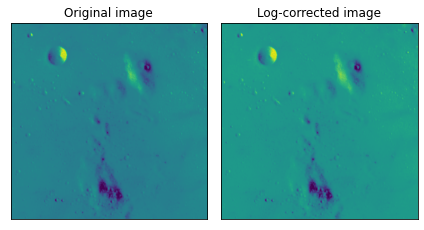

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(moon)
ax2.imshow(moon_corr)
ax1.set(title="Original image")
ax2.set(title="Log-corrected image")
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
fig.tight_layout()

### <font color='yellow'> Using cuda.jit </font>

In [ ]:
import math

# Example 1.5: 2D kernel
@cuda.jit
def adjust_log_cuda(inp, gain, out):
    ix, iy = cuda.grid(2) # The first index is the fastest dimension
    threads_per_grid_x, threads_per_grid_y = cuda.gridsize(2) #  threads per grid dimension
    
    n0, n1 = inp.shape # The last index is the fastest dimension
    # Stride each dimension independently
    for i0 in range(iy, n0, threads_per_grid_y):
        for i1 in range(ix, n1, threads_per_grid_x):
            out[i0, i1] = gain * math.log2(1 + inp[i0, i1])

In [ ]:
def moon_driver():
  threads_per_block_2d = (16, 16)  #  256 threads total
  blocks_per_grid_2d = (64, 64)

  moon_gpu = cuda.to_device(moon)
  moon_corr_gpu = cuda.device_array_like(moon_gpu)

  adjust_log_cuda[blocks_per_grid_2d, threads_per_block_2d](moon_gpu, 0.9, moon_corr_gpu)
  moon_corr = moon_corr_gpu.copy_to_host()

  return moon_corr

%timeit moon_driver

21.8 ns ± 0.285 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [ ]:
moon_corr_cuda = moon_driver()

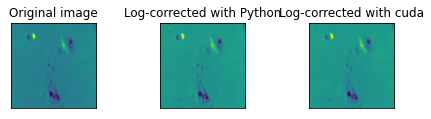

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(moon)
ax2.imshow(moon_corr)
ax3.imshow(moon_corr_cuda)

ax1.set(title="Original image")
ax2.set(title="Log-corrected with Python")
ax3.set(title ="Log-corrected with cuda")

for ax in (ax1, ax2, ax3):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

fig.tight_layout()

## Binary Search

In [ ]:
from numba import njit, cuda
import numba
from numba.types import int32, float32

import numpy as np

from time import time
from warnings import warn
from pdb import set_trace

bits = 32
nb_float = float32
nb_int = int32
np_float = np.float32
np_int = np.int32

N = 1000000
arr = np.random.randint(0, N, N)
arr.shape

(1000000,)

In [ ]:
sorted_arr = sorted(arr)

### <font color='yellow'> Pure Python </font>

In [ ]:
def binary_search(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1
 
# Function call
%timeit binary_search(sorted_arr, np.random.randint(0, N))

10.3 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### <font color='yellow'> Using numba.jit </font>

In [ ]:
@numba.jit
def binary_search_numba(arr, x):
    low = 0
    high = len(arr) - 1
    mid = 0
 
    while low <= high:
 
        mid = (high + low) // 2
 
        # If x is greater, ignore left half
        if arr[mid] < x:
            low = mid + 1
 
        # If x is smaller, ignore right half
        elif arr[mid] > x:
            high = mid - 1
 
        # means x is present at mid
        else:
            return mid
 
    # If we reach here, then the element was not present
    return -1
 
# Function call
%timeit binary_search_numba(sorted_arr, np.random.randint(0, N))

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'arr' of function 'binary_search_numba'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-16-f9c264b77655>", line 2:
@numba.jit
def binary_search_numba(arr, x):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


2.15 s ± 50 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Histogram plot with cuda

In [ ]:
import numpy as np

from numba import cuda

@cuda.jit
def histogram(x, xmin, xmax, histogram_out):
    nbins = histogram_out.shape[0]
    bin_width = (xmax - xmin) / nbins

    start = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(start, x.shape[0], stride):
        bin_number = np.int32((x[i] - xmin)/bin_width)
        if bin_number >= 0 and bin_number < histogram_out.shape[0]:
            print('in range', x[i], bin_number)
            cuda.atomic.add(histogram_out, bin_number, 1) # synchronization
        else:
        	print('out of range', x[i], bin_number)

x = np.random.normal(size=100, loc=0, scale=1).astype(np.float32)
xmin = np.float32(-4.0)
xmax = np.float32(4.0)
histogram_out = np.zeros(shape=10, dtype=np.int32)

histogram[64, 64](x, xmin, xmax, histogram_out)

print('input count:', x.shape[0])
print('histogram:', histogram_out)
print('count:', histogram_out.sum())

input count: 100
histogram: [ 0  1  6 16 34 23 17  3  0  0]
count: 100


/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.7/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


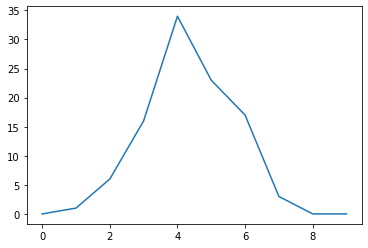

In [ ]:
plt.plot(histogram_out)

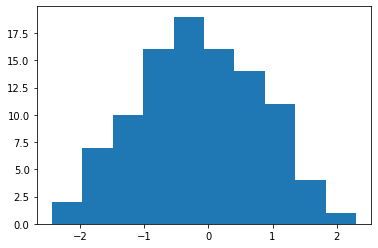

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x)
plt.show()